<a href="https://colab.research.google.com/github/geryabra/SMP/blob/main/(ADF)_2023_2024__Bidsell_compare.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Setup (install + imports + config)**

In [1]:
# Install (Colab usually has these, but just in case)
!pip -q install openpyxl

import os, re, tempfile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# -------- Paths / constants --------
BOOK1_PATH = "/content/Book1.xlsx"   # <- upload as this name
BOOK2_PATH = "/content/Book2.xlsx"   # <- upload as this name
OUTDIR     = "/content/outputs"

FREQ_30MIN = "30min"
W1, W2 = 48, 336        # 1 day, 1 week (in 30-min slots)

os.makedirs(OUTDIR, exist_ok=True)

# In-memory cache for interactive plots
LAST_RESULTS = {}   # {"BidSell DA1": DataFrame, ...}
LAST_SUMMARY = None


In [2]:
from google.colab import files

print("Upload Book1.xlsx and Book2.xlsx (exact names):")
uploaded = files.upload()  # choose your local Excel files

# Sanity: show what's uploaded
list(uploaded.keys())


Upload Book1.xlsx and Book2.xlsx (exact names):


Saving Book1.xlsx to Book1.xlsx
Saving Book2.xlsx to Book2.xlsx


['Book1.xlsx', 'Book2.xlsx']

In [4]:
# 3) טעינה מינימלית ובניית SMP (Date+Time → datetime, ממוצע Avarege_DA1-DA10)
# -----------------------------------------------------------------------------
import re
import pandas as pd
import numpy as np

# קוראים את הקובץ (נקרא הכל ואז נסנן לעמודות הרלוונטיות)
raw = pd.read_excel(BOOK1_PATH, engine="openpyxl")

# נורמליזציה פשוטה לשמות עמודות
raw.columns = [str(c).strip() for c in raw.columns]

# מאתרים עמודות Date ו-Time (בהתאמה רופפת לאותיות קטנות/גדולות)
date_col = next((c for c in raw.columns if c.lower() == "date"), None)
time_col = next((c for c in raw.columns if c.lower() == "time"), None)
if date_col is None or time_col is None:
    raise ValueError("חייבים עמודות 'Date' וגם 'Time' ב-Book1.xlsx")

# מאתרים את עמודות Avarege_DA1..DA10 (רג'קס תופס גם Avarage/Avarege, לא תלוי רישיות)
da_cols = [c for c in raw.columns if re.match(r"(?i)^ava?r?ege_da.*$", c)]
if len(da_cols) == 0:
    raise ValueError("לא נמצאו עמודות Avarege_DA ב-Book1.xlsx")

# נשמור רק את העמודות הדרושות
df = raw[[date_col, time_col] + da_cols].copy()

# המרה ל-datetime משילוב Date+Time
dt = pd.to_datetime(df[date_col].astype(str) + " " + df[time_col].astype(str), errors="coerce")
df = df.assign(DateTime=dt).dropna(subset=["DateTime"]).drop(columns=[date_col, time_col])
df = df.sort_values("DateTime").set_index("DateTime")

# המרת DA לעשרוניות + טיפול במל"ל בסיסי
df[da_cols] = df[da_cols].apply(pd.to_numeric, errors="coerce")
df[da_cols] = df[da_cols].interpolate(method="time").fillna(method="bfill").fillna(method="ffill")

# יצירת מדד SMP כממוצע שורה
smp = pd.DataFrame({"SMP": df[da_cols].mean(axis=1)})
smp.index.name = "DateTime"

print(f"Rows loaded: {len(smp):,} | DA columns: {len(da_cols)} → unified to 'SMP'")
smp.head(3)

Rows loaded: 33,603 | DA columns: 1 → unified to 'SMP'


/tmp/ipython-input-3844514387.py:34: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[da_cols] = df[da_cols].interpolate(method="time").fillna(method="bfill").fillna(method="ffill")


,SMP
DateTime,
2023-01-01 00:00:00,109.698
2023-01-01 00:30:00,109.698
2023-01-01 01:00:00,109.698


/tmp/ipython-input-379065078.py:56: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[da_cols] = df[da_cols].fillna(method="bfill").fillna(method="ffill")


[INFO] Segmented ADF done. Segments: 46


,year,month,period,n,adf_stat,p_value,lags,conclusion
0,2023,1,Off-Peak,620,NaN,NaN,NaN,Insufficient data
1,2023,1,Peak,868,NaN,NaN,NaN,Insufficient data
2,2023,2,Off-Peak,560,NaN,NaN,NaN,Insufficient data
3,2023,2,Peak,784,NaN,NaN,NaN,Insufficient data
4,2023,3,Off-Peak,620,NaN,NaN,NaN,Insufficient data
5,2023,3,Peak,850,-1.866424,3.480173e-01,17.0,Non-stationary
6,2023,4,Off-Peak,600,NaN,NaN,NaN,Insufficient data
7,2023,4,Peak,840,NaN,NaN,NaN,Insufficient data
8,2023,5,Off-Peak,620,NaN,NaN,NaN,Insufficient data
9,2023,5,Peak,868,NaN,NaN,NaN,Insufficient data


[OK] Results saved → /content/outputs/segmented_adf_SMP.csv


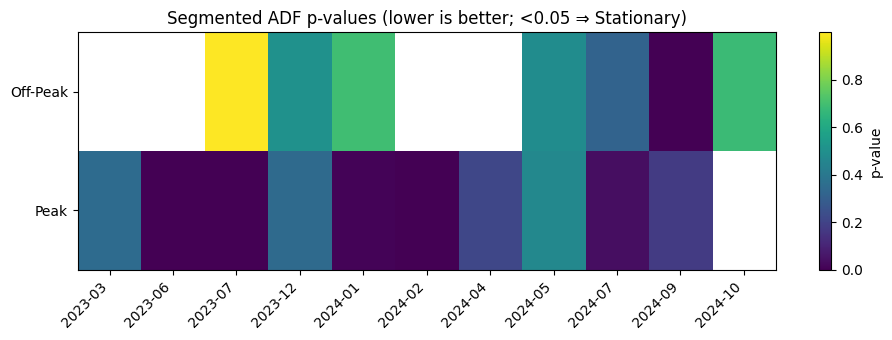


Overall stability ratio (p<0.05): 35.29%


In [7]:
# (Seg-ADF) בדיקת יציבות מקוטעת של סדרת SMP: פילוח חודשי + Peak/Off-Peak
# -----------------------------------------------------------------------------
# מה התא עושה:
# 1) קורא את Book1.xlsx ושומר רק Date, Time, Avarege_DA1–DA10
# 2) בונה DateTime, מיישר לגריד 30min, משלים פערים באינטרפולציה
# 3) יוצר SMP = ממוצע שורה של עשרת הערוצים
# 4) מגדיר Peak/Off-Peak (שעות 08:00–22:00 כ-Peak; ניתן לשנות בקלות)
# 5) מריץ ADF לכל תת-מקטע (חודש × Peak/Off-Peak), רק אם יש מספיק דגימות
# 6) מפיק טבלת תוצאות, מסקנה (p<0.05), שומר CSV, ומציג Heatmap של p-value

import re, os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ------------- פרמטרים לשינוי מהיר -------------
PEAK_START_HOUR = 8    # כולל
PEAK_END_HOUR   = 22   # לא כולל (כלומר 08:00–21:59 נחשב Peak)
MIN_SAMPLES_ADF = 200  # מינימום תצפיות להרצת ADF במקטע
OUT_CSV = os.path.join(OUTDIR, "segmented_adf_SMP.csv")

# ------------- טעינה וסינון עמודות -------------
raw = pd.read_excel(BOOK1_PATH, engine="openpyxl")
raw.columns = [str(c).strip() for c in raw.columns]

date_col = next((c for c in raw.columns if c.lower()=="date"), None)
time_col = next((c for c in raw.columns if c.lower()=="time"), None)
if date_col is None or time_col is None:
    raise ValueError("נדרשות עמודות 'Date' ו-'Time' ב-Book1.xlsx")

# כל עמודות ה-DA (תופס Avarege/Avrage/Average בתבנית כללית)
da_cols = [c for c in raw.columns if re.match(r"(?i)^ava?r?ege_da.*$", c)]
if not da_cols:
    raise ValueError("לא נמצאו עמודות Avarege_DA1..DA10")

df = raw[[date_col, time_col] + da_cols].copy()

# ------------- בניית אינדקס זמן -------------
dt = pd.to_datetime(df[date_col].astype(str) + " " + df[time_col].astype(str), errors="coerce")
df = (df.assign(DateTime=dt)
        .dropna(subset=["DateTime"])
        .drop(columns=[date_col, time_col])
        .sort_values("DateTime")
        .set_index("DateTime"))

# Remove duplicate timestamps from the index
df = df[~df.index.duplicated(keep='first')]

# ------------- המרות מספריות ואינטרפולציה מבוססת-זמן -------------
df[da_cols] = df[da_cols].apply(pd.to_numeric, errors="coerce")
# יישור לגריד חצי-שעתי מלא
full_idx = pd.date_range(df.index.min(), df.index.max(), freq=FREQ_30MIN)
df = df.reindex(full_idx)
# השלמת פערים
df[da_cols] = df[da_cols].interpolate(method="time", limit_direction="both")
df[da_cols] = df[da_cols].fillna(method="bfill").fillna(method="ffill")

# ------------- בניית SMP -------------
smp = pd.DataFrame({"SMP": df[da_cols].mean(axis=1)})
smp.index.name = "DateTime"

# ------------- הגדרת Peak / Off-Peak -------------
hours = smp.index.hour
smp["period"]  = np.where((hours >= PEAK_START_HOUR) & (hours < PEAK_END_HOUR), "Peak", "Off-Peak")
smp["year"]    = smp.index.year
smp["month"]   = smp.index.month

# ------------- ADF לכל מקטע -------------
!pip -q install statsmodels
from statsmodels.tsa.stattools import adfuller

rows = []
for (yr, mo, per), g in smp.groupby(["year", "month", "period"]):
    series = g["SMP"].dropna()
    n = len(series)
    if n < MIN_SAMPLES_ADF or series.nunique() < 5:
        rows.append({
            "year": yr, "month": mo, "period": per,
            "n": n, "adf_stat": np.nan, "p_value": np.nan,
            "lags": np.nan, "conclusion": "Insufficient data"
        })
        continue
    try:
        res = adfuller(series, autolag="AIC")
        adf_stat, pval, lags, nobs, crit, _ = res
        concl = "Stationary" if pval < 0.05 else "Non-stationary"
        rows.append({
            "year": yr, "month": mo, "period": per,
            "n": int(nobs), "adf_stat": adf_stat, "p_value": pval,
            "lags": lags, "conclusion": concl
        })
    except Exception as e:
        rows.append({
            "year": yr, "month": mo, "period": per,
            "n": n, "adf_stat": np.nan, "p_value": np.nan,
            "lags": np.nan, "conclusion": f"Error: {e}"
        })

res_df = pd.DataFrame(rows).sort_values(["year","month","period"]).reset_index(drop=True)
print(f"[INFO] Segmented ADF done. Segments: {len(res_df)}")
display_cols = ["year","month","period","n","adf_stat","p_value","lags","conclusion"]
display(res_df[display_cols].head(12))

# ------------- שמירת טבלה -------------
res_df.to_csv(OUT_CSV, index=False)
print(f"[OK] Results saved → {OUT_CSV}")

# ------------- Heatmap של p-value (לפי חודש; שורות=Period, עמודות=YYYY-MM) -------------
try:
    res_df["ym"] = res_df["year"].astype(str) + "-" + res_df["month"].astype(str).str.zfill(2)
    pivot = res_df.pivot_table(index="period", columns="ym", values="p_value", aggfunc="mean")
    fig, ax = plt.subplots(figsize=(min(16, 2 + 0.7*len(pivot.columns)), 3.5))
    im = ax.imshow(pivot.values, aspect="auto", interpolation="nearest")
    ax.set_yticks(range(len(pivot.index))); ax.set_yticklabels(pivot.index)
    ax.set_xticks(range(len(pivot.columns))); ax.set_xticklabels(pivot.columns, rotation=45, ha="right")
    ax.set_title("Segmented ADF p-values (lower is better; <0.05 ⇒ Stationary)")
    fig.colorbar(im, ax=ax, label="p-value")
    plt.tight_layout(); plt.show()
except Exception as e:
    print(f"[WARN] Heatmap skipped: {e}")

# ------------- תקציר החלטה כוללת -------------
valid = res_df["p_value"].notna()
if valid.any():
    stable_ratio = (res_df.loc[valid, "p_value"] < 0.05).mean()
    print(f"\nOverall stability ratio (p<0.05): {stable_ratio:.2%}")
else:
    print("\nNo valid segments to summarize.")

In [ ]:
# 4) בדיקת Stationarity הכי פשוטה: ADF (Augmented Dickey-Fuller)
# ---------------------------------------------------------------
!pip -q install statsmodels

from statsmodels.tsa.stattools import adfuller

series = smp["SMP"].dropna()

adf_stat, pval, lags, nobs, crit, _ = adfuller(series, autolag="AIC")

print("ADF Test on SMP")
print(f"  ADF statistic : {adf_stat:.6f}")
print(f"  p-value       : {pval:.6g}")
print(f"  # lags used   : {lags}")
print(f"  # observations: {nobs}")
for k, v in crit.items():
    print(f"  Critical {k}: {v:.6f}")

print("\nConclusion:")
if pval < 0.05:
    print("  p < 0.05 → דוחים H0 → הסדרה Stationary (תחנתית).")
else:
    print("  p ≥ 0.05 → לא דוחים H0 → הסדרה אינה Stationary, שקול Differencing.")


ADF Test on SMP
  ADF statistic : -7.663127
  p-value       : 1.66813e-11
  # lags used   : 51
  # observations: 33551
  Critical 1%: -3.430545
  Critical 5%: -2.861626
  Critical 10%: -2.566816

Conclusion:
  p < 0.05 → דוחים H0 → הסדרה Stationary (תחנתית).


**Core helpers (timestamp, column detection, alignment)**

In [ ]:
def _ensure_dir(p):
    if p and not os.path.exists(p): os.makedirs(p, exist_ok=True)

def _best_timestamp_col(df: pd.DataFrame) -> pd.Series:
    best, best_score = None, -1
    for c in df.columns:
        try:
            p = pd.to_datetime(df[c], errors="coerce")
        except Exception:
            continue
        score = p.notna().sum()
        if score > best_score and score >= max(10, int(len(df)*0.05)):
            best, best_score = p, score
    if best is None:
        raise ValueError("No timestamp-like column found (tried Date+Time and autodetect).")
    return best

def make_ts(df: pd.DataFrame) -> pd.Series:
    cols = {str(c).strip(): c for c in df.columns}
    if "Date" in cols and "Time" in cols:
        return pd.to_datetime(
            df[cols["Date"]].astype(str).str.strip()+" "+df[cols["Time"]].astype(str).str.strip(),
            errors="coerce"
        )
    return _best_timestamp_col(df)

def identify_bidsell_cols(df: pd.DataFrame) -> list:
    return [c for c in df.columns if isinstance(c, str) and c.startswith("BidSell") and ("limit" not in c.lower())]

def resample_align_30min(df1: pd.DataFrame, df2: pd.DataFrame, col: str) -> pd.DataFrame:
    """Align one BidSell column from Book1 vs Book2 on a uniform 30-min grid."""
    a = df1[["ts", col]].rename(columns={col: "price1"}).dropna(subset=["ts"])
    b = df2[["ts", col]].rename(columns={col: "price2"}).dropna(subset=["ts"])
    a = (a.set_index("ts").sort_index().groupby(level=0).mean(numeric_only=True))
    b = (b.set_index("ts").sort_index().groupby(level=0).mean(numeric_only=True))
    m = pd.merge(a, b, left_index=True, right_index=True, how="inner").sort_index()
    if m.empty:
        return pd.DataFrame(columns=["ts","price1","price2","diff","pct_diff"])
    idx = pd.date_range(m.index.min(), m.index.max(), freq=FREQ_30MIN)
    m = m.reindex(idx)
    # small gaps interpolation (≤1h)
    m["price1"] = m["price1"].interpolate(limit=2)
    m["price2"] = m["price2"].interpolate(limit=2)
    m = m.reset_index().rename(columns={"index":"ts"})
    m["diff"] = m["price1"] - m["price2"]
    m["pct_diff"] = m["diff"] / (m["price2"].abs() + 1e-9)
    return m


**Metrics + fast flags (no per-DA plots)**

In [ ]:
def compute_metrics(df: pd.DataFrame) -> dict:
    out = {"n_points": int(df.shape[0])}
    if df.empty:
        out.update({"corr_pearson": np.nan, "MAE": np.nan, "RMSE": np.nan, "MAPE_vs_Book2": np.nan})
        return out
    p1 = df["price1"].ffill().bfill().values
    p2 = df["price2"].ffill().bfill().values
    corr = float(np.corrcoef(p1, p2)[0,1]) if (np.nanstd(p1)>0 and np.nanstd(p2)>0) else np.nan
    diff = p1 - p2
    out["corr_pearson"] = corr
    out["MAE"]  = float(np.nanmean(np.abs(diff)))
    out["RMSE"] = float(np.sqrt(np.nanmean(diff**2)))
    out["MAPE_vs_Book2"] = float(np.mean(np.abs(diff) / np.maximum(1e-9, np.abs(p2))))
    return out

def add_fast_flags(df: pd.DataFrame) -> pd.DataFrame:
    """Rolling z-scores + simple change-point proxy (kept for summaries if needed)."""
    if df.empty:
        out = df.copy()
        for c in ["roll_mean_48","roll_std_48","z48","roll_mean_336","roll_std_336","z336","cp_flag","anomaly_flag"]:
            out[c] = np.nan
        return out
    out = df.copy()
    out["roll_mean_48"] = out["diff"].rolling(W1, min_periods=W1//2).mean()
    out["roll_std_48"]  = out["diff"].rolling(W1, min_periods=W1//2).std()
    out["z48"]          = (out["diff"] - out["roll_mean_48"]) / (out["roll_std_48"] + 1e-9)

    out["roll_mean_336"] = out["diff"].rolling(W2, min_periods=W2//4).mean()
    out["roll_std_336"]  = out["diff"].rolling(W2, min_periods=W2//4).std()
    out["z336"]          = (out["diff"] - out["roll_mean_336"]) / (out["roll_std_336"] + 1e-9)

    shift = out["roll_mean_48"] - out["roll_mean_48"].shift(W1)
    cp_score = shift.abs()
    med = np.nanmedian(cp_score); mad = np.nanmedian(np.abs(cp_score - med)) + 1e-9
    out["cp_flag"] = (cp_score > (med + 3.5*mad)).astype(int)

    out["anomaly_flag"] = ((out["z48"].abs()>3.2) | (out["z336"].abs()>3.5)).fillna(False).astype(int)
    return out


**Pipeline (loads two Excel files, builds cache, saves CSV, no DA-plots)**

In [ ]:
# === Cell 5 — Pipeline (GLOBAL row-drop + Peak/Off-peak rolling stats) ===

def load_book(path, sheet_name=0, debug=False) -> pd.DataFrame:
    """
    קורא קובץ Excel, בונה ts, ממיר את כל עמודות ה-BidSell למספריות,
    ואז מבצע DROP GLOBALLY: משאיר רק שורות שבהן *כל* ה-BidSell > 0 (ולא NaN).
    """
    if not os.path.exists(path):
        raise FileNotFoundError(path)

    df = pd.read_excel(path, sheet_name=sheet_name)
    df.columns = [str(c).strip() for c in df.columns]

    # בניית חותמת זמן
    df["ts"] = make_ts(df)

    # זיהוי עמודות BidSell*
    bid_cols = identify_bidsell_cols(df)
    if len(bid_cols) == 0:
        raise ValueError(f"No 'BidSell*' columns found in {os.path.basename(path)}")

    # המרה למספרים
    for c in bid_cols:
        df[c] = pd.to_numeric(df[c], errors="coerce")

    # מסיכה גלובלית: כל ה-BidSell>0 וגם ts לא חסר
    mask_all_positive = df[bid_cols].gt(0).all(axis=1) & df["ts"].notna()

    if debug:
        before, after = len(df), int(mask_all_positive.sum())
        print(f"[load_book] {os.path.basename(path)}: kept {after}/{before} rows "
              f"({before-after} dropped) with ALL BidSell>0")

    df = df.loc[mask_all_positive].reset_index(drop=True)
    return df


def _add_peak_offpeak_stats(M: pd.DataFrame) -> pd.DataFrame:
    """
    מוסיף דגלי Peak/Off-peak ועושה חישובי rolling נפרדים לכל קבוצה.
    Peak: 17:00 <= time < 23:00  → חלונות 12 (יום) ו-84 (שבוע)
    Off-peak: אחרת               → חלונות 36 (יום) ו-252 (שבוע)
    """
    if M.empty:
        # עמודות ריקות אם אין נתונים
        for c in ["pct_diff","period","is_peak",
                  "roll_mean_48","roll_std_48","z48",
                  "roll_mean_336","roll_std_336","z336"]:
            M[c] = np.nan
        M["period"] = M["period"].astype("object")
        M["is_peak"] = M.get("is_peak", pd.Series(index=M.index, dtype=float))
        return M

    M = M.sort_values("ts").copy()
    M["hour"] = M["ts"].dt.hour
    M["minute"] = M["ts"].dt.minute

    # דגל פסגה (1) / שפל (0): 17:00 <= t < 23:00
    M["is_peak"] = (((M["hour"] >= 17) & (M["hour"] < 23))).astype(int)
    M["period"]  = np.where(M["is_peak"] == 1, "Peak", "Off-peak")

    # הפרש יחסי תמידי (ללא תלות בקבוצה)
    M["pct_diff"] = M["diff"] / (M["price2"].abs() + 1e-9)

    # פונקציית עזר לחישוב גלגולים בתוך כל קבוצה
    def _apply_group(sub: pd.DataFrame) -> pd.DataFrame:
        if sub.empty:
            return sub
        sub = sub.sort_values("ts").copy()
        if sub["period"].iloc[0] == "Peak":
            n1, n2 = 12, 84      # 6 שעות ביום → 12 טיקים; שבוע → 84
        else:
            n1, n2 = 36, 252     # 18 שעות ביום → 36 טיקים; שבוע → 252

        sub["roll_mean_48"]  = sub["diff"].rolling(n1, min_periods=max(1, n1//2)).mean()
        sub["roll_std_48"]   = sub["diff"].rolling(n1, min_periods=max(1, n1//2)).std()
        sub["z48"]           = (sub["diff"] - sub["roll_mean_48"]) / (sub["roll_std_48"] + 1e-9)

        sub["roll_mean_336"] = sub["diff"].rolling(n2, min_periods=max(1, n2//2)).mean()
        sub["roll_std_336"]  = sub["diff"].rolling(n2, min_periods=max(1, n2//2)).std()
        sub["z336"]          = (sub["diff"] - sub["roll_mean_336"]) / (sub["roll_std_336"] + 1e-9)

        return sub

    # חישוב גלגולים נפרד לכל period
    M = M.groupby("period", group_keys=False).apply(_apply_group)

    # ניקוי עמודות עזר
    M = M.drop(columns=["hour","minute"])
    return M


def run_pipeline(book1_path=BOOK1_PATH,
                 book2_path=BOOK2_PATH,
                 outdir=OUTDIR,
                 sheet_name=0,
                 keep_in_memory=True,
                 cache_only=None,
                 cache_max_rows=None,
                 debug=False):
    """
    טוען את שני הקבצים (עם Drop גלובלי ALL BidSell>0),
    מיישר כל BidSell משותף על גריד 30min, מחשב diff,
    ואז מוסיף סטטיסטיקות Peak/Off-peak נפרדות (pct_diff + rolling + z).
    שומר CSV פר-DA + טבלת Summary, וממלא Cache בזיכרון לגרפי הסיכום.
    """
    global LAST_RESULTS, LAST_SUMMARY
    _ensure_dir(outdir)

    # קריאת קבצים עם סינון גלובלי
    b1 = load_book(book1_path, sheet_name=sheet_name, debug=debug)
    b2 = load_book(book2_path, sheet_name=sheet_name, debug=debug)

    # איתור עמודות משותפות
    cols1 = set(identify_bidsell_cols(b1))
    cols2 = set(identify_bidsell_cols(b2))
    common = sorted(cols1 & cols2)
    if not common:
        raise ValueError("No common 'BidSell*' columns found between Book1 and Book2.")

    if keep_in_memory:
        LAST_RESULTS.clear()

    summary_rows = []

    for col in common:
        print(f"[+] Processing {col} ...")

        # יישור לגריד 30min + diff
        M = resample_align_30min(b1, b2, col)

        # סטטיסטיקות Peak/Off-peak נפרדות
        M = _add_peak_offpeak_stats(M)

        # מדדים כלליים (עדיין על diff הגלובלי; זה בסדר לשימוש בסיכום)
        metrics = compute_metrics(M)
        metrics["BidSell"] = col
        summary_rows.append(metrics)

        # שמירה ל-CSV פר DA
        safe_name = re.sub(r"[^A-Za-z0-9._-]+", "_", col)
        csv_path = os.path.join(outdir, f"{safe_name}_paired_enriched.csv")
        M.to_csv(csv_path, index=False)

        # cache לזיכרון (לגרפים המסכמים)
        if keep_in_memory and (cache_only is None or col in cache_only):
            M_cache = M if cache_max_rows is None else M.tail(cache_max_rows)
            LAST_RESULTS[col] = M_cache.copy()

    # טבלת Summary
    summary = pd.DataFrame(summary_rows).sort_values("BidSell").reset_index(drop=True)
    summary_path = os.path.join(outdir, "book_pair_summary.csv")
    summary.to_csv(summary_path, index=False)
    LAST_SUMMARY = summary.copy()

    print("\nDone.")
    print("Outputs dir:", outdir)
    print("Summary:", summary_path)

    return (summary, LAST_RESULTS) if keep_in_memory else summary


**Summary plots (ALL-DA only; labels SMP/Supplier)**

In [ ]:
def _natural_da_order(names):
    def key(n):
        m = re.search(r"DA(\d+)", n)
        return (int(m.group(1)) if m else 10**9, n)
    return sorted(names, key=key)

def plot_all_bids_diff_overlay(cache=None, outdir=OUTDIR,
                               resample_rule="1D", smooth_days=7,
                               outname="all_bids_diff_overlay.png",
                               names=None):
    """Overlay of daily median diff (Book1 − Book2) for all BidSell."""
    cache = cache or LAST_RESULTS
    if not cache:
        raise RuntimeError("Cache is empty. Run run_pipeline(keep_in_memory=True) first.")
    if names is None:
        names = _natural_da_order(list(cache.keys()))
    else:
        names = _natural_da_order([n for n in names if n in cache])

    plt.figure(figsize=(12,5))
    for name in names:
        df = cache[name]
        s = df.set_index("ts")["diff"].resample(resample_rule).median()
        if smooth_days and smooth_days > 1:
            s = s.rolling(smooth_days, min_periods=max(1, smooth_days//2)).mean()
        plt.plot(s.index, s.values, label=name, linewidth=1.3, alpha=0.9)

    plt.title("All BidSell — Daily diff overlay (SMP − Supplier)")
    plt.xlabel("Date"); plt.ylabel("Daily median diff")
    plt.grid(alpha=0.2); plt.legend(ncol=3, fontsize=9); plt.tight_layout()
    path = os.path.join(outdir, outname); plt.savefig(path, dpi=120); plt.show()
    print("Saved:", path)

def plot_all_bids_summary_band(cache=None, outdir=OUTDIR,
                               resample_rule="1D", smooth_days=7,
                               outname="all_bids_diff_summary_band.png"):
    """Mean diff across all BidSell with ±1 std band (Smp − Supplier)."""
    cache = cache or LAST_RESULTS
    if not cache:
        raise RuntimeError("Cache is empty. Run run_pipeline(keep_in_memory=True) first.")

    series = []
    for name, df in cache.items():
        s = df.set_index("ts")["diff"].resample(resample_rule).median().rename(name)
        series.append(s)
    ALL = pd.concat(series, axis=1).sort_index()
    if smooth_days and smooth_days > 1:
        ALL = ALL.rolling(smooth_days, min_periods=max(1, smooth_days//2)).mean()

    mean = ALL.mean(axis=1); std = ALL.std(axis=1)
    plt.figure(figsize=(12,5))
    plt.plot(mean.index, mean.values, label="Mean diff (SMP − Supplier)", linewidth=2.0)
    plt.fill_between(mean.index, (mean-std).values, (mean+std).values, alpha=0.2, label="±1 std")
    plt.title("All BidSell — Daily diff mean ± 1σ (SMP − Supplier)")
    plt.xlabel("Date"); plt.ylabel("Diff"); plt.grid(alpha=0.2); plt.legend(); plt.tight_layout()
    path = os.path.join(outdir, outname); plt.savefig(path, dpi=120); plt.show()
    print("Saved:", path)


**Run pipeline + make the two summary plots**

[+] Processing BidSell DA1 ...


/tmp/ipython-input-2280887456.py:86: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  M = M.groupby("period", group_keys=False).apply(_apply_group)


[+] Processing BidSell DA10 ...


/tmp/ipython-input-2280887456.py:86: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  M = M.groupby("period", group_keys=False).apply(_apply_group)


[+] Processing BidSell DA2 ...


/tmp/ipython-input-2280887456.py:86: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  M = M.groupby("period", group_keys=False).apply(_apply_group)


[+] Processing BidSell DA3 ...


/tmp/ipython-input-2280887456.py:86: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  M = M.groupby("period", group_keys=False).apply(_apply_group)


[+] Processing BidSell DA4 ...


/tmp/ipython-input-2280887456.py:86: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  M = M.groupby("period", group_keys=False).apply(_apply_group)


[+] Processing BidSell DA5 ...


/tmp/ipython-input-2280887456.py:86: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  M = M.groupby("period", group_keys=False).apply(_apply_group)


[+] Processing BidSell DA6 ...


/tmp/ipython-input-2280887456.py:86: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  M = M.groupby("period", group_keys=False).apply(_apply_group)


[+] Processing BidSell DA7 ...


/tmp/ipython-input-2280887456.py:86: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  M = M.groupby("period", group_keys=False).apply(_apply_group)


[+] Processing BidSell DA8 ...


/tmp/ipython-input-2280887456.py:86: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  M = M.groupby("period", group_keys=False).apply(_apply_group)


[+] Processing BidSell DA9 ...


/tmp/ipython-input-2280887456.py:86: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  M = M.groupby("period", group_keys=False).apply(_apply_group)



Done.
Outputs dir: /content/outputs
Summary: /content/outputs/book_pair_summary.csv


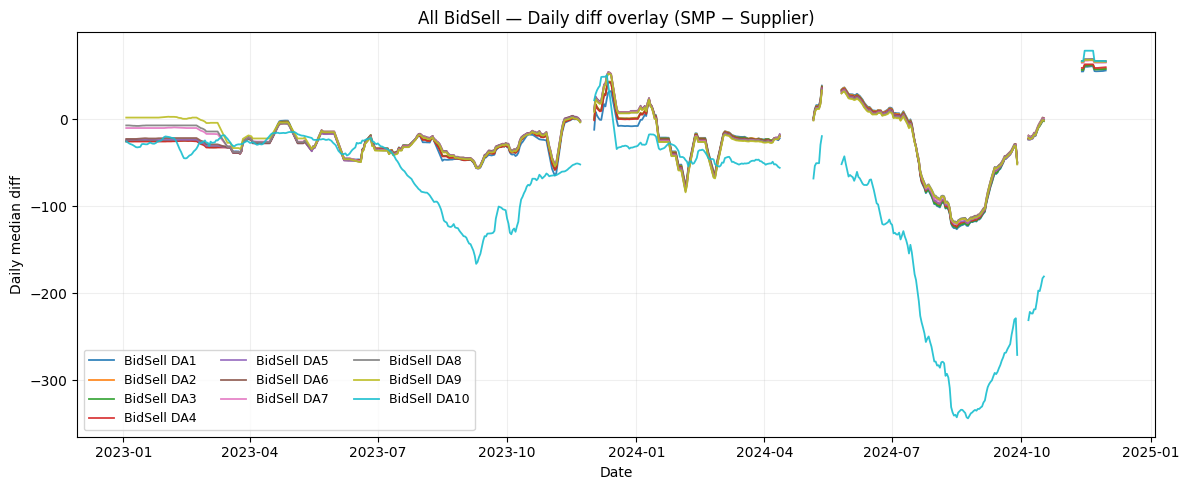

Saved: /content/outputs/all_bids_diff_overlay.png


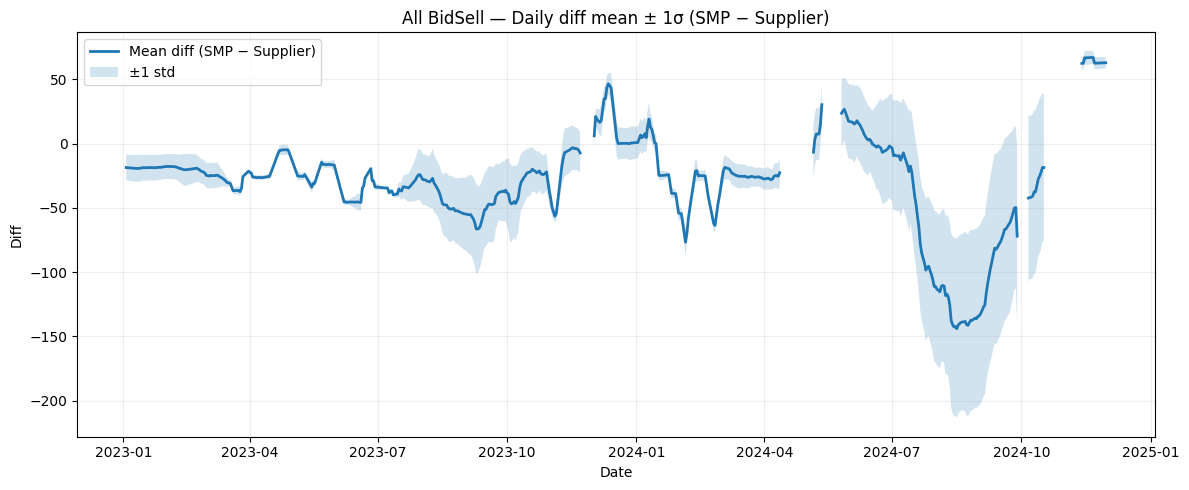

Saved: /content/outputs/all_bids_diff_summary_band.png


,n_points,corr_pearson,MAE,RMSE,MAPE_vs_Book2,BidSell
0,33600,0.495911,36.759983,47.915392,0.220852,BidSell DA1
1,33600,0.419712,100.399860,136.869497,0.307709,BidSell DA10
2,33600,0.503382,35.838756,47.195251,0.214122,BidSell DA2
3,33600,0.505834,36.022031,47.450261,0.214126,BidSell DA3
4,33600,0.512615,36.054656,47.267628,0.214211,BidSell DA4


In [ ]:
summary, cache = run_pipeline(keep_in_memory=True)

# Two summary charts (no per-DA time-series):
plot_all_bids_diff_overlay(cache)
plot_all_bids_summary_band(cache)

summary.head()


**Cell — Anomaly summary (Peak vs Off-peak) + plots**

Saved summary: /content/outputs/anomaly_summary_by_DA.csv


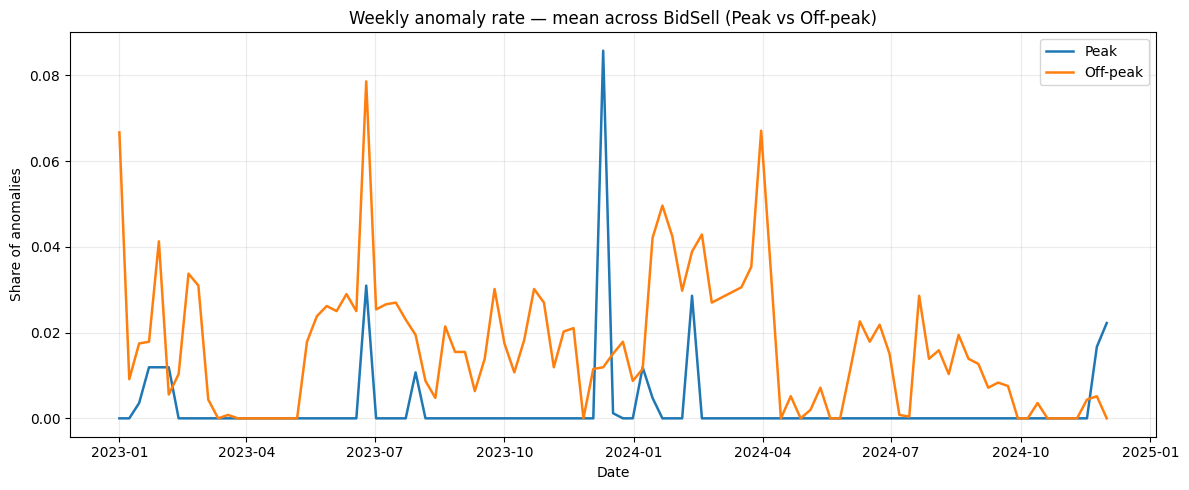

Saved plot: /content/outputs/anomaly_rate_weekly_peak_vs_offpeak.png


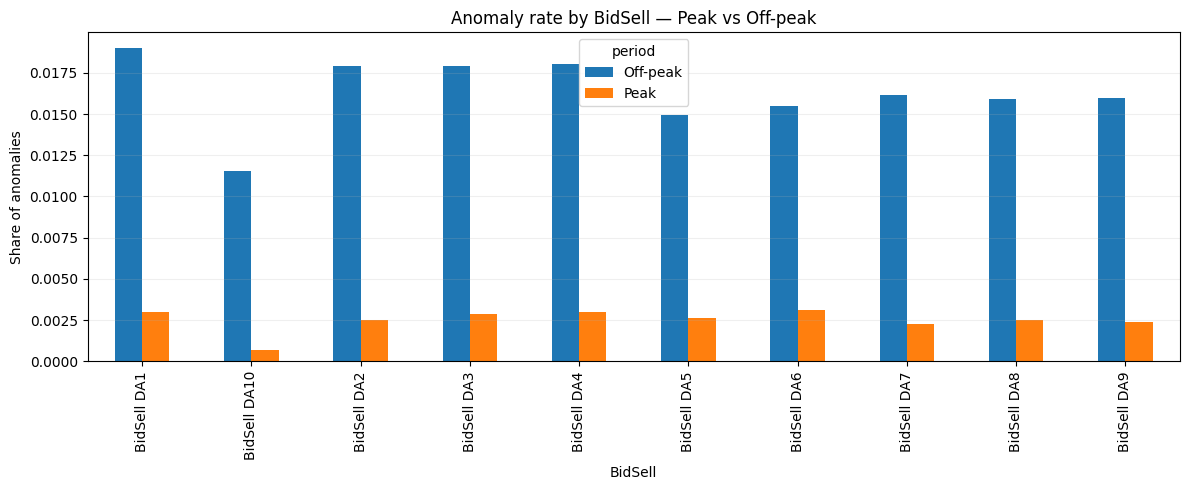

Saved plot: /content/outputs/anomaly_rate_by_DA_peak_vs_offpeak.png


,mean_rate,median_rate,std_rate
period,,,
Off-peak,0.016290,0.016052,0.002140
Peak,0.002488,0.002560,0.000684


In [ ]:
# === Cell — Anomaly summary (Peak vs Off-peak) ===
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def _ensure_anomaly_flag(df, thr_short=3.2, thr_long=3.5):
    """Ensure anomaly_flag exists; compute from z48/z336 if needed."""
    if "anomaly_flag" not in df.columns:
        if ("z48" not in df.columns) or ("z336" not in df.columns):
            # חירום: לחשב Z גלובלי קלאסי (אם אין עמודות z מהפייפליין)
            diff = df["diff"]
            rm48 = diff.rolling(48,  min_periods=24).mean()
            rs48 = diff.rolling(48,  min_periods=24).std()
            rz48 = (diff - rm48) / (rs48 + 1e-9)

            rm336 = diff.rolling(336, min_periods=84).mean()
            rs336 = diff.rolling(336, min_periods=84).std()
            rz336 = (diff - rm336) / (rs336 + 1e-9)
            flag = ((rz48.abs() > thr_short) | (rz336.abs() > thr_long)).fillna(False).astype(int)
        else:
            flag = ((df["z48"].abs() > thr_short) | (df["z336"].abs() > thr_long)).fillna(False).astype(int)
        df = df.copy()
        df["anomaly_flag"] = flag
    return df

def _ensure_period(df):
    """Ensure period/is_peak exist; if לא קיימים – הפקה על בסיס ts."""
    if "period" not in df.columns or "is_peak" not in df.columns:
        df = df.copy()
        df["hour"] = df["ts"].dt.hour
        df["is_peak"] = (((df["hour"] >= 17) & (df["hour"] < 23))).astype(int)
        df["period"]  = np.where(df["is_peak"] == 1, "Peak", "Off-peak")
        df = df.drop(columns=["hour"], errors="ignore")
    return df

def build_anomaly_summary(last_results: dict, outdir=OUTDIR):
    """Returns:
       - summary_by_da: טבלת סיכום לכל DA (Peak/Off-peak: count + rate)
       - weekly_mean: סדרת זמן שבועית של שיעור אנומליות (ממוצע Across DA) ל-2 תקופות
       - df_all: דאטה מאוחד (למקרה שתרצה עוד פרוסות)
    """
    frames = []
    for name, df in last_results.items():
        if df.empty:
            continue
        d = _ensure_period(df)
        d = _ensure_anomaly_flag(d)
        d = d.copy()
        d["BidSell"] = name
        frames.append(d)

    if not frames:
        raise RuntimeError("No data in LAST_RESULTS. Run the pipeline first (keep_in_memory=True).")

    all_df = pd.concat(frames, ignore_index=True)
    all_df = all_df.sort_values("ts")

    # --- סיכום לפי DA ו-period ---
    grp = all_df.groupby(["BidSell", "period"], as_index=False).agg(
        n_points=("anomaly_flag", "count"),
        n_anom=("anomaly_flag", "sum"),
    )
    grp["rate"] = grp["n_anom"] / grp["n_points"].replace(0, np.nan)
    grp["rate_pct"] = 100 * grp["rate"]

    # --- סדרת זמן שבועית של שיעור אנומליות ממוצע Across DA ---
    # קודם: ממוצע שבועי לכל DA בנפרד, ואז ממוצע Across DA (משקל שווה לכל DA)
    weekly = (all_df
              .set_index("ts")
              .groupby(["BidSell", "period"])["anomaly_flag"]
              .resample("W").mean()
              .reset_index())

    weekly_mean = (weekly
                   .groupby(["period", "ts"], as_index=False)["anomaly_flag"]
                   .mean()
                   .rename(columns={"anomaly_flag": "mean_rate"}))

    # שמירה ל-CSV
    os.makedirs(outdir, exist_ok=True)
    path_csv = os.path.join(outdir, "anomaly_summary_by_DA.csv")
    grp.sort_values(["BidSell", "period"]).to_csv(path_csv, index=False)
    print("Saved summary:", path_csv)

    return grp, weekly_mean, all_df

# --- הפקה ---
summary_by_da, weekly_mean, df_all = build_anomaly_summary(LAST_RESULTS, outdir=OUTDIR)

# --- גרף 1: שיעור אנומליות שבועי (Peak/Off-peak) באותו גרף ---
plt.figure(figsize=(12,5))
for period in ["Peak", "Off-peak"]:
    s = weekly_mean[weekly_mean["period"] == period]
    plt.plot(s["ts"], s["mean_rate"], label=period, linewidth=1.8)
plt.title("Weekly anomaly rate — mean across BidSell (Peak vs Off-peak)")
plt.xlabel("Date"); plt.ylabel("Share of anomalies")
plt.grid(alpha=0.25); plt.legend(); plt.tight_layout()
out_path1 = os.path.join(OUTDIR, "anomaly_rate_weekly_peak_vs_offpeak.png")
plt.savefig(out_path1, dpi=130); plt.show()
print("Saved plot:", out_path1)

# --- גרף 2: סיכום לפי DA (עמודות Peak/Off-peak זו לצד זו) ---
pivot_rates = (summary_by_da.pivot(index="BidSell", columns="period", values="rate")
               .reindex(sorted(summary_by_da["BidSell"].unique()), axis=0))

ax = pivot_rates.plot(kind="bar", figsize=(12,5))
ax.set_title("Anomaly rate by BidSell — Peak vs Off-peak")
ax.set_xlabel("BidSell"); ax.set_ylabel("Share of anomalies")
ax.grid(alpha=0.2, axis="y"); plt.tight_layout()
out_path2 = os.path.join(OUTDIR, "anomaly_rate_by_DA_peak_vs_offpeak.png")
plt.savefig(out_path2, dpi=130); plt.show()
print("Saved plot:", out_path2)

# --- הדפסה קצרה של סטטיסטיקות (ממוצע/חציון across DA) ---
stats = (summary_by_da
         .groupby("period")["rate"]
         .agg(mean_rate="mean", median_rate="median", std_rate="std"))
display(stats)


Diagnostics (all points):
           total_points  anomalies  anomaly_rate
period                                         
Off-peak        252000       4105      0.016290
Peak             84000        209      0.002488 

Saved: /content/outputs/anomaly_mean_diff_D_per_sample.csv
Saved plot: /content/outputs/anomaly_mean_diff_D_per_sample.png


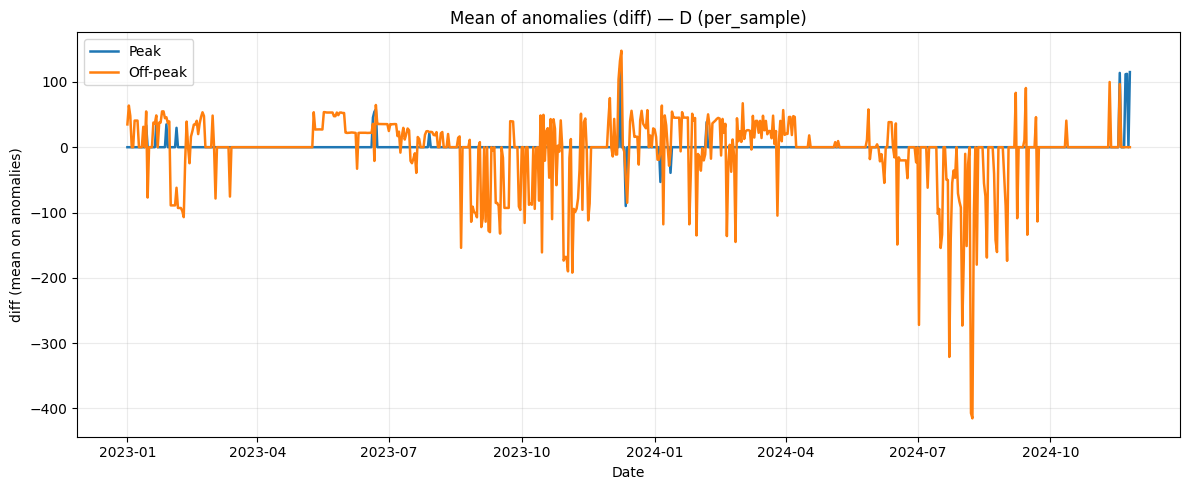

In [ ]:
# === Cell — Mean of anomalies by day (Peak vs Off-peak), with proper weighting & continuity ===
import os, glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

OUTDIR = globals().get("OUTDIR", "/content/outputs")

# פרמטרים:
RESAMPLE_RULE = "D"          # "D" יומי | "W" שבועי
VALUE_KIND    = "diff"       # "diff" או "abs_diff"
AGG_MODE      = "per_sample" # "per_sample" (שקילה במס' אנומליות) | "per_DA" (שווה-משקל ל-DA)
FILL_NO_ANOM_AS_ZERO = True  # להחליף ימים ללא אנומליות ל-0 כדי ליצור רציפות
SAVE = True

def _load_cache_from_outputs(outdir=OUTDIR):
    cache = {}
    for fp in glob.glob(os.path.join(outdir, "BidSell_*_paired_enriched.csv")):
        name = os.path.basename(fp).replace("_paired_enriched.csv", "")
        df = pd.read_csv(fp, parse_dates=["ts"])
        cache[name] = df
    return cache

def _ensure_period(df):
    if "period" in df.columns and "is_peak" in df.columns:
        return df
    d = df.copy()
    d["hour"] = d["ts"].dt.hour
    d["is_peak"] = (((d["hour"] >= 17) & (d["hour"] < 23))).astype(int)
    d["period"]  = np.where(d["is_peak"] == 1, "Peak", "Off-peak")
    return d.drop(columns=["hour"], errors="ignore")

def _ensure_anomaly_flag(df, thr_short=3.2, thr_long=3.5):
    if "anomaly_flag" in df.columns:
        return df
    d = df.copy()
    if ("z48" in d.columns) and ("z336" in d.columns):
        d["anomaly_flag"] = ((d["z48"].abs() > thr_short) | (d["z336"].abs() > thr_long)).fillna(False).astype(int)
    else:
        diff = d["diff"]
        rm48 = diff.rolling(48,  min_periods=24).mean();  rs48 = diff.rolling(48,  min_periods=24).std()
        rm336= diff.rolling(336, min_periods=84).mean();  rs336= diff.rolling(336, min_periods=84).std()
        z48  = (diff - rm48)   / (rs48  + 1e-9)
        z336 = (diff - rm336)  / (rs336 + 1e-9)
        d["anomaly_flag"] = ((z48.abs() > thr_short) | (z336.abs() > thr_long)).fillna(False).astype(int)
    return d

# מקור נתונים: LAST_RESULTS אם קיים, אחרת CSV-ים
cache = globals().get("LAST_RESULTS", None)
if not cache:
    cache = _load_cache_from_outputs(OUTDIR)
if not cache:
    raise RuntimeError("No data found. Run the pipeline or export CSVs to OUTDIR.")

# איחוד וסטנדרטיזציה
frames = []
for nm, df in cache.items():
    if df.empty:
        continue
    d = _ensure_period(df)
    d = _ensure_anomaly_flag(d)
    d = d.copy()
    d["BidSell"] = nm
    if VALUE_KIND == "abs_diff":
        d["val"] = d["diff"].abs()
        ylab = "|diff| (mean on anomalies)"
    else:
        d["val"] = d["diff"]
        ylab = "diff (mean on anomalies)"
    frames.append(d)

ALL = pd.concat(frames, ignore_index=True).sort_values("ts")

# דיאגנוסטיקה: כמה אנומליות יש ב-Peak/Off-peak
diag = (ALL.groupby("period")["anomaly_flag"]
          .agg(total_points="count", anomalies="sum"))
diag["anomaly_rate"] = diag["anomalies"] / diag["total_points"].replace(0, np.nan)
print("Diagnostics (all points):\n", diag, "\n")

# מסננים רק אנומליות
A = ALL[ALL["anomaly_flag"] == 1].copy()
if A.empty:
    raise RuntimeError("No anomalies after filtering anomaly_flag==1.")

# אגירה לפי מצב
if AGG_MODE == "per_sample":
    # ממוצע של כל האנומליות (שקילה טבעית במס' האנומליות)
    series = (A.set_index("ts")
                .groupby("period")["val"]
                .resample(RESAMPLE_RULE).mean()
                .reset_index()
                .rename(columns={"val":"mean_val"}))
elif AGG_MODE == "per_DA":
    # קודם ממוצע לכל DA ואז ממוצע Across-DA (שווה משקל ל-DA)
    per_da = (A.set_index("ts")
                .groupby(["BidSell","period"])["val"]
                .resample(RESAMPLE_RULE).mean()
                .reset_index())
    series = (per_da.groupby(["period","ts"], as_index=False)["val"]
                    .mean()
                    .rename(columns={"val":"mean_val"}))
else:
    raise ValueError("AGG_MODE must be 'per_sample' or 'per_DA'.")

# רציפות: לבנות אינדקס מלא של תאריכים לכל period ולהשלים חוסרים
min_ts = series["ts"].min(); max_ts = series["ts"].max()
full_idx = pd.date_range(min_ts.floor("D"), max_ts.ceil("D"), freq=RESAMPLE_RULE)
filled = []
for period in ["Peak","Off-peak"]:
    s = series[series["period"] == period].set_index("ts").reindex(full_idx)
    s.index.name = "ts"
    s["period"] = period
    if FILL_NO_ANOM_AS_ZERO:
        s["mean_val"] = s["mean_val"].fillna(0.0)  # אין אנומליות ביום → 0 בגרף
    filled.append(s.reset_index())
series_full = pd.concat(filled, ignore_index=True)

# שמירה לטבלה
os.makedirs(OUTDIR, exist_ok=True)
csv_out = os.path.join(OUTDIR, f"anomaly_mean_{VALUE_KIND}_{RESAMPLE_RULE}_{AGG_MODE}.csv")
series_full.to_csv(csv_out, index=False)
print("Saved:", csv_out)

# Plot
plt.figure(figsize=(12,5))
for period, color in [("Peak","#1f77b4"), ("Off-peak","#ff7f0e")]:
    s = series_full[series_full["period"] == period]
    if not s.empty:
        plt.plot(s["ts"], s["mean_val"], label=period, color=color, linewidth=1.8)
plt.title(f"Mean of anomalies ({VALUE_KIND}) — {RESAMPLE_RULE} ({AGG_MODE})")
plt.xlabel("Date"); plt.ylabel(ylab)
plt.grid(alpha=0.25); plt.legend(); plt.tight_layout()
if SAVE:
    png_out = os.path.join(OUTDIR, f"anomaly_mean_{VALUE_KIND}_{RESAMPLE_RULE}_{AGG_MODE}.png")
    plt.savefig(png_out, dpi=130); print("Saved plot:", png_out)
plt.show()

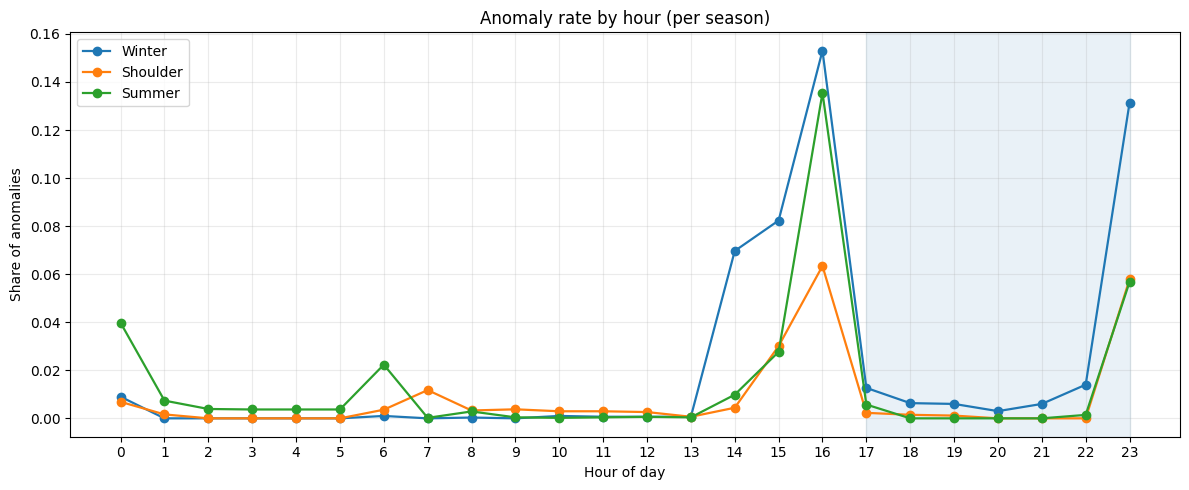

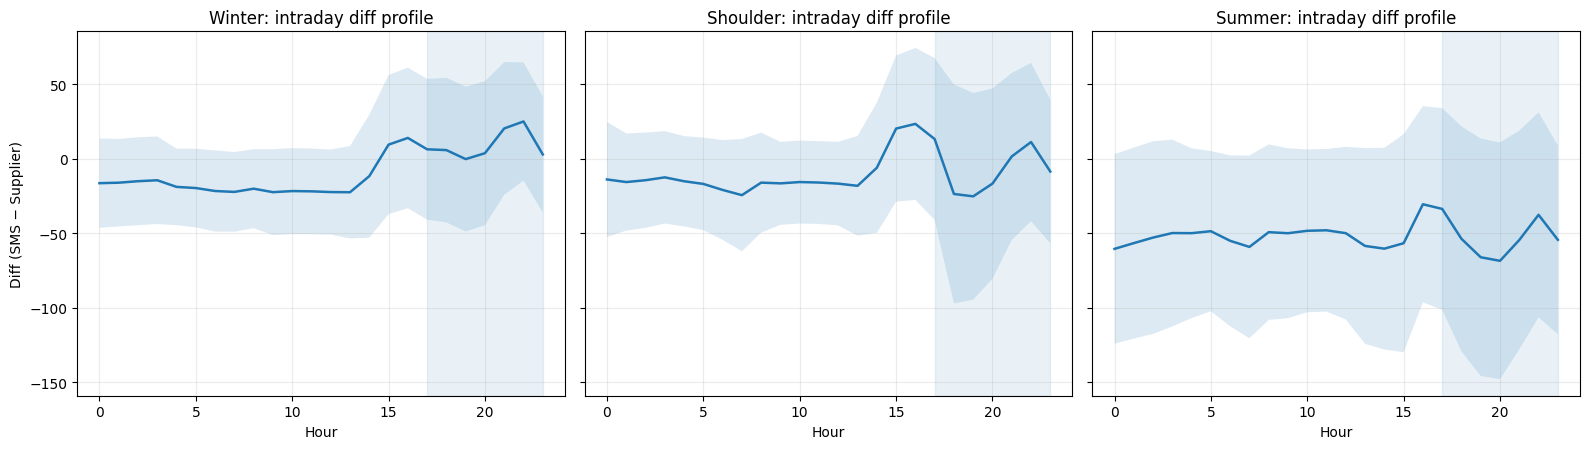

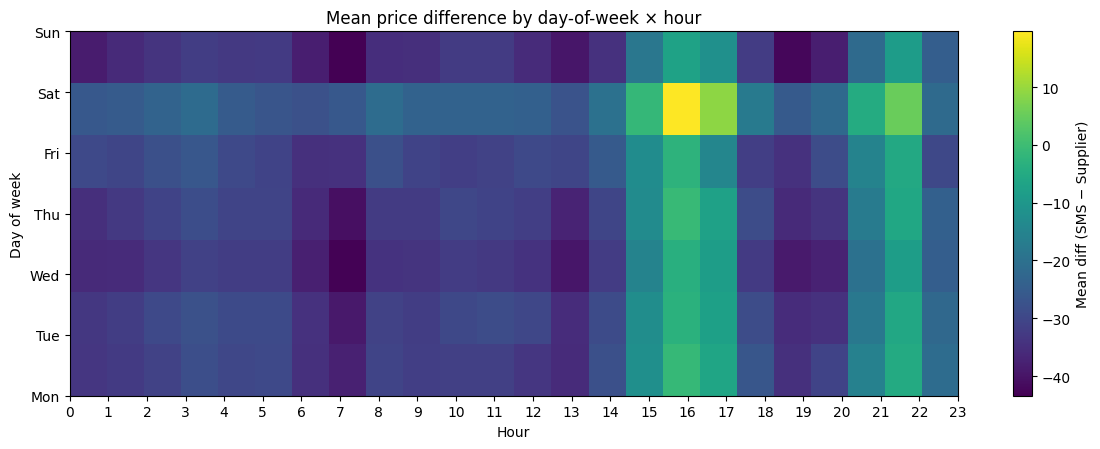

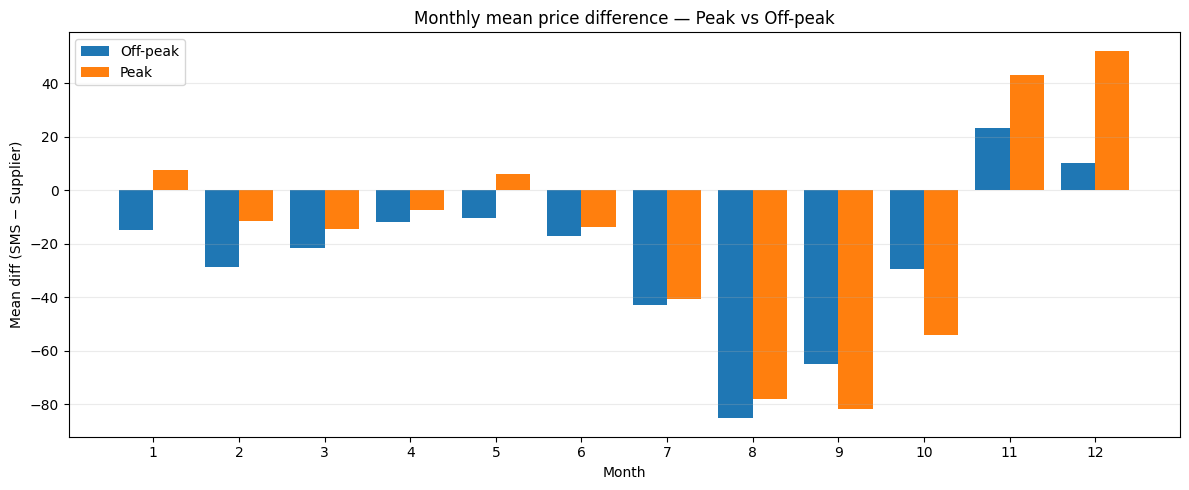

Saved:
 - /content/outputs/fig_anom_rate_by_hour_season.png
 - /content/outputs/fig_intraday_profile_by_season.png
 - /content/outputs/fig_heatmap_dow_hour.png
 - /content/outputs/fig_monthly_mean_diff_by_period.png


In [ ]:
# === Cell — 4 figures (SMS vs Supplier) ===
import os, glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# היכן שמורים ה-CSV-ים (אותה תיקייה שבה הרצת את ה-pipeline)
OUTDIR = globals().get("OUTDIR", "/content/outputs")
os.makedirs(OUTDIR, exist_ok=True)

# ---------- עזר: טעינה/השלמות ----------
def _load_cache_from_outputs(outdir=OUTDIR):
    cache = {}
    for fp in glob.glob(os.path.join(outdir, "BidSell_*_paired_enriched.csv")):
        nm = os.path.basename(fp).replace("_paired_enriched.csv", "")
        cache[nm] = pd.read_csv(fp, parse_dates=["ts"])
    return cache

def _ensure_period(df):
    if "period" in df.columns and "is_peak" in df.columns:
        return df
    d = df.copy()
    d["hour"] = d["ts"].dt.hour
    d["is_peak"] = (((d["hour"] >= 17) & (d["hour"] < 23))).astype(int)
    d["period"]  = np.where(d["is_peak"]==1, "Peak", "Off-peak")
    return d.drop(columns=["hour"], errors="ignore")

def _ensure_season(df):
    if "season" in df.columns:
        return df
    d = df.copy()
    m = d["ts"].dt.month
    # חלוקה בעבודה שלנו: Winter (12,1,2), Summer (6,7,8,9), Shoulder (3,4,5,10,11)
    d["season"] = np.select(
        [
            m.isin([12,1,2]),
            m.isin([6,7,8,9]),
            m.isin([3,4,5,10,11]),
        ],
        ["Winter", "Summer", "Shoulder"],
        default="Shoulder"
    )
    return d

def _ensure_anomaly_flag(df, thr_short=3.2, thr_long=3.5):
    if "anomaly_flag" in df.columns:
        return df
    d = df.copy()
    if ("z48" in d.columns) and ("z336" in d.columns):
        d["anomaly_flag"] = ((d["z48"].abs() > thr_short) | (d["z336"].abs() > thr_long)).fillna(False).astype(int)
    else:
        # fallback: חישוב z מהיר (לא צפוי כשמריצים pipeline שלנו)
        diff = d["diff"]
        rm48  = diff.rolling(48,  min_periods=24).mean(); rs48  = diff.rolling(48,  min_periods=24).std()
        rm336 = diff.rolling(336, min_periods=84).mean(); rs336 = diff.rolling(336, min_periods=84).std()
        z48  = (diff - rm48)  / (rs48  + 1e-9)
        z336 = (diff - rm336) / (rs336 + 1e-9)
        d["anomaly_flag"] = ((z48.abs() > thr_short) | (z336.abs() > thr_long)).fillna(False).astype(int)
    return d

# מקור: LAST_RESULTS אם קיים, אחרת טעינה מהדיסק
cache = globals().get("LAST_RESULTS", None)
if not cache:
    cache = _load_cache_from_outputs(OUTDIR)
if not cache:
    raise RuntimeError("No data found. Run the pipeline first or place CSVs in OUTDIR.")

# איחוד כל ה-DA + השלמות
frames = []
for nm, df in cache.items():
    if df.empty:
        continue
    d = df.copy()
    # כאן diff מחושב כבר בפייפליין כ: SMS - Supplier (כלומר price1 - price2)
    d = _ensure_period(d)
    d = _ensure_season(d)
    d = _ensure_anomaly_flag(d)
    d["BidSell"] = nm
    frames.append(d)

ALL = pd.concat(frames, ignore_index=True).sort_values("ts")

# ---------- 1) Anomaly rate by hour (per season) ----------
rate_by_hour = (ALL
    .groupby(["season", ALL["ts"].dt.hour])["anomaly_flag"]
    .mean()
    .reset_index()
    .rename(columns={"ts":"hour", "anomaly_flag":"rate"}))

plt.figure(figsize=(12,5))
for season, color in [("Winter","#1f77b4"), ("Shoulder","#ff7f0e"), ("Summer","#2ca02c")]:
    s = rate_by_hour[rate_by_hour["season"]==season]
    plt.plot(s["hour"], s["rate"], marker="o", label=season, linewidth=1.6)
# הדגשת חלון הפסגה 17–23
plt.axvspan(17, 23, color="#4c92c3", alpha=0.12)
plt.title("Anomaly rate by hour (per season)")
plt.xlabel("Hour of day"); plt.ylabel("Share of anomalies")
plt.xticks(range(0,24,1)); plt.grid(alpha=0.25); plt.legend(); plt.tight_layout()
p1 = os.path.join(OUTDIR, "fig_anom_rate_by_hour_season.png")
plt.savefig(p1, dpi=140); plt.show()

# ---------- 2) Intraday diff profile per season (mean ±1 std) ----------
fig, axes = plt.subplots(1,3, figsize=(16,4.6), sharey=True)
order = [("Winter","#1f77b4"), ("Shoulder","#ff7f0e"), ("Summer","#2ca02c")]
for ax,(season,_c) in zip(axes, order):
    S = ALL[ALL["season"]==season]
    prof = (S.groupby(S["ts"].dt.hour)["diff"]
              .agg(mean="mean", std="std").reset_index())
    x = prof["ts"]; mu = prof["mean"]; sd = prof["std"]
    ax.plot(x, mu, linewidth=1.8)
    ax.fill_between(x, mu-sd, mu+sd, alpha=0.15)
    ax.axvspan(17, 23, color="#4c92c3", alpha=0.12)
    ax.set_title(f"{season}: intraday diff profile")
    ax.set_xlabel("Hour"); ax.grid(alpha=0.25)
axes[0].set_ylabel("Diff (SMS − Supplier)")
plt.tight_layout()
p2 = os.path.join(OUTDIR, "fig_intraday_profile_by_season.png")
plt.savefig(p2, dpi=140); plt.show()

# ---------- 3) Heatmap: mean diff by day-of-week × hour ----------
dow = ALL["ts"].dt.dayofweek  # Mon=0,...,Sun=6
hour = ALL["ts"].dt.hour
hm = ALL.assign(dow=dow, hour=hour).groupby(["dow","hour"])["diff"].mean().unstack()

plt.figure(figsize=(12,4.6))
im = plt.imshow(hm.values, aspect="auto", origin="lower",
                extent=[0,23,0,6], cmap="viridis")
plt.colorbar(im, label="Mean diff (SMS − Supplier)")
plt.yticks(ticks=range(0,7),
           labels=["Mon","Tue","Wed","Thu","Fri","Sat","Sun"])
plt.xticks(range(0,24,1))
plt.title("Mean price difference by day-of-week × hour")
plt.xlabel("Hour"); plt.ylabel("Day of week")
plt.tight_layout()
p3 = os.path.join(OUTDIR, "fig_heatmap_dow_hour.png")
plt.savefig(p3, dpi=140); plt.show()

# ---------- 4) Monthly mean diff — Peak vs Off-peak ----------
ALL["month"] = ALL["ts"].dt.month
m = (ALL.groupby(["month","period"])["diff"]
        .mean().unstack().fillna(0.0).reindex(range(1,13), fill_value=0.0))

plt.figure(figsize=(12,5))
w = 0.4
x = np.arange(1,13)
plt.bar(x - w/2, m.get("Off-peak", pd.Series(0,index=m.index)), width=w, label="Off-peak")
plt.bar(x + w/2, m.get("Peak",     pd.Series(0,index=m.index)), width=w, label="Peak")
plt.title("Monthly mean price difference — Peak vs Off-peak")
plt.xlabel("Month"); plt.ylabel("Mean diff (SMS − Supplier)")
plt.xticks(range(1,13)); plt.grid(alpha=0.25, axis="y"); plt.legend(); plt.tight_layout()
p4 = os.path.join(OUTDIR, "fig_monthly_mean_diff_by_period.png")
plt.savefig(p4, dpi=140); plt.show()

print("Saved:")
for p in [p1,p2,p3,p4]:
    print(" -", p)